In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Author: Feng Jin. Contact info: fengjin@email.arizona.edu
import argparse, os
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import tensorflow as tf
from keras import backend as K
from keras import optimizers
from keras.layers import Input, Dense, Flatten, Lambda, Concatenate, Reshape, \
    TimeDistributed, LSTM, RepeatVector, SimpleRNN, Activation
from keras.models import Model, load_model
from keras.callbacks import TensorBoard
from keras.losses import mse
from keras.utils import plot_model

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
        #   'figure.figsize': (19.2, 10.8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

class data_preproc:
    def __init__(self):
        # One motion pattern is as (self.frames_per_pattern, self.points_per_frame, self.features_per_point)
        self.frames_per_pattern     = 10 # For 1 second for 10 fps radar rate
        self.points_per_frame       = 64 # We want to oversample every radar frame to 64 points while keeping the mean and variance the same
        self.features_per_point     = 4  # The radar can provides us (x, y, z, Doppler, RCS), but we only keep the first four feature, i.e. (x, y, z, Doppler)

        # Train and test data split ratio
        self.split_ratio            = 0.8

        # Rotation matrix due to tilt angle
        tilt_angle  = -10.0 # degrees
        self.height = 1.8   # meters
        self.rotation_matrix = np.array([[1.0, 0.0, 0.0],\
                                        [0.0, np.cos(np.deg2rad(tilt_angle)), -np.sin(np.deg2rad(tilt_angle))],\
                                        [0.0, np.sin(np.deg2rad(tilt_angle)), np.cos(np.deg2rad(tilt_angle))]])
             
    def load_bin(self, binfile_path, fortrain=True):
        # Record centroid history for analysis purpose
        centroidX_his = []
        centroidY_his = []
        centroidZ_his = []

        # Load the recorded bin file
        raw_pointcloud = np.load(binfile_path, allow_pickle=True)

        # Accumulated the motion patterns with (self.frames_per_pattern) frames
        total_pattern = []
        for idx in range(len(raw_pointcloud)-self.frames_per_pattern):
            total_pattern.append(raw_pointcloud[idx : (idx + self.frames_per_pattern)])

        # Original point vector in the .bin file:
        #   [frame number, point ID, target ID, \\ Basic information
        #   centroidX, centroidY, centroidZ, centroidVelocityX, centroidVelocityY, centroidVelocityZ, \\ Centorid information
        #   range, azimuth angle, elevation angle, Doppler, SNR, noise level] \\ Point information
        # Extract the feature vector (delta_x, delta_y, z, D, pointRCS) from the original point vector and do data oversampling proposed in the paper
        total_processed_pattern = []
        total_processed_no_norm = []
        for pattern in total_pattern:
            # Get the centroid information from the very first frame in a pattern and do coordiante transformation
            # As the centroid is already in the radar Cartesian coordinates, we just need to transfer it to the ground Cartesian coordinates
            centroidX, centroidY, centroidZ, centroidVx, centroidVy, centroidVz = pattern[0][0][3], pattern[0][0][4], pattern[0][0][5], pattern[0][0][6], pattern[0][0][7], pattern[0][0][8]
            results      = np.matmul(self.rotation_matrix, np.array([centroidX,centroidY,centroidZ]))
            centroidX    = results[0]
            centroidY    = results[1]
            centroidZ    = results[2] + self.height

            # Record the centroid history over time
            centroidX_his.append(centroidX)
            centroidY_his.append(centroidY)
            centroidZ_his.append(centroidZ)

            processed_pattern  = []
            for frame in pattern:
                processed_frame = []
                for point in frame:        
                    # Get the original point information.
                    pointR, pointAZ, pointEL, pointD, pointSNR, pointNoise = point[9], point[10], point[11], point[12], point[13], point[14]

                    # Get the point's position in the Cartesian coord and then do coordiante transformation
                    pointX      = pointR*np.cos(pointEL)*np.sin(pointAZ)
                    pointY      = pointR*np.cos(pointEL)*np.cos(pointAZ)
                    pointZ      = pointR*np.sin(pointEL)
                    results     = np.matmul(self.rotation_matrix, np.array([pointX, pointY, pointZ]))
                    pointX      = results[0]
                    pointY      = results[1]
                    pointZ      = results[2] + self.height
                    
                    # Subtract the point's position from the centroid in the very first frame in a motion pattern
                    delta_x     = pointX - centroidX
                    delta_y     = pointY - centroidY
                    delta_z     = pointZ
                    delta_D     = pointD
                    pointRCS    = 4*10*np.log10(pointR) + pointSNR*0.1 + pointNoise*0.1 # in dBsm

                    # Form the feature vector for each frame
                    feature_vector = [delta_x, delta_y, delta_z, delta_D, pointRCS]
                    processed_frame.append(feature_vector[0:self.features_per_point]) # Only keep 3D spatial info and the Doppler
                processed_pattern.append(processed_frame)
                # Do the data oversampling proposed in the paper
                processed_pattern_oversampled = self.proposed_oversampling(processed_pattern)
            total_processed_pattern.append(processed_pattern_oversampled)

        total_processed_pattern_np = np.array(total_processed_pattern)
        
        # Train and test split
        split_idx   = int(total_processed_pattern_np.shape[0]*self.split_ratio)
        traindata   = total_processed_pattern_np[0:split_idx]
        testdata    = total_processed_pattern_np[split_idx:]

        if fortrain is True: # For training, need data split to obtain both training and testing dataset
            print("INFO: Total normal motion pattern data shape: " + str(total_processed_pattern_np.shape))
            print("INFO: Training motion pattern data shape" + str(traindata.shape))
            print("INFO: Testing motion pattern data shape" + str(testdata.shape))
            return traindata, testdata
        else: # For inference on anomaly dataset
            print("INFO: Total inference motion pattern data shape: " + str(total_processed_pattern_np.shape))
            return total_processed_pattern, centroidZ_his

    def proposed_oversampling(self, processed_pointcloud):
        # # Check the input
        # point_list = []
        # for frame in processed_pointcloud:
        #     point_list.extend(frame)
        # point_list_np  = np.array(point_list)
        # assert (point_list_np.shape[-1] == self.features_per_point), ("ERROR: Input processed_pointcloud has different feature length rather than %s!" %(self.features_per_point))

        # Do the data oversampling
        processed_pointcloud_oversampled = []
        for frame in processed_pointcloud:
            frame_np = np.array(frame)
            # Check if it's empty frame
            N = self.points_per_frame
            M = frame_np.shape[0]
            assert (M != 0), "ERROR: empty frame detected!"
            # Rescale and padding
            mean        = np.mean(frame_np, axis=0)
            sigma       = np.std(frame_np, axis=0)
            frame_np    = np.sqrt(N/M)*frame_np + mean - np.sqrt(N/M)*mean # Rescale
            frame_oversampled = frame_np.tolist()
            frame_oversampled.extend([mean]*(N-M)) # Padding with mean
            # # Check if mean and sigma keeps the same. Comment for saving time.
            # new_mean    = np.mean(np.array(frame_oversampled), axis=0)
            # new_sigma   = np.std(np.array(frame_oversampled), axis=0)
            # assert np.sum(np.abs(new_mean-mean))<1e-5, ("ERROR: Mean rescale and padding error!")
            # assert np.sum(np.abs(new_sigma-sigma))<1e-5, ("ERROR: Sigma rescale and padding error!")
            processed_pointcloud_oversampled.append(frame_oversampled)

        processed_pointcloud_oversampled_np = np.array(processed_pointcloud_oversampled)
        assert (processed_pointcloud_oversampled_np.shape[-2] == self.points_per_frame), ("ERROR: The new_frame_data has different number of points per frame rather than %s!" %(self.points_per_frame))    
        assert (processed_pointcloud_oversampled_np.shape[-1] == self.features_per_point), ("ERROR: The new_frame_data has different feature length rather than %s!" %(self.features_per_point))    

        return processed_pointcloud_oversampled_np

class autoencoder_mdl:
    def __init__(self, model_dir):
        self.model_dir = model_dir

    # Variational Recurrent Autoencoder (VRAE)
    def VRAE_train(self, train_data, test_data):
        # In one motion pattern we have
        n_frames       = 10
        n_points       = 64
        n_features     = 4
        
        # Dimension is going down for encoding. Decoding is just a reflection of encoding.
        n_intermidiate    = 64
        n_latentdim       = 16
        
        # Define input
        inputs                  = Input(shape=(n_frames, n_points, n_features))
        input_flatten           = TimeDistributed(Flatten(None))(inputs)

        # VAE: q(z|X). Input: motion pattern. Output: mean and log(sigma^2) for q(z|X).
        input_flatten           = TimeDistributed(Dense(n_intermidiate, activation='tanh'))(input_flatten)
        Z_mean                  = TimeDistributed(Dense(n_latentdim, activation=None), name='qzx_mean')(input_flatten)
        Z_log_var               = TimeDistributed(Dense(n_latentdim, activation=None), name='qzx_log_var')(input_flatten)
        def sampling(args): # Instead of sampling from Q(z|X), sample epsilon = N(0,I), z = z_mean + sqrt(var) * epsilon
            Z_mean, Z_log_var   = args
            batch_size          = K.shape(Z_mean)[0]
            n_frames            = K.int_shape(Z_mean)[1]
            n_latentdim         = K.int_shape(Z_mean)[2]
            # For reproducibility, we set the seed=37
            epsilon             = K.random_normal(shape=(batch_size, n_frames, n_latentdim), mean=0., stddev=1.0, seed=None)
            Z                   = Z_mean + K.exp(0.5*Z_log_var) * epsilon # The reparameterization trick
            return  Z
        # VAE: sampling z ~ q(z|X) using reparameterization trick. Output: samples of z.
        Z                       = Lambda(sampling)([Z_mean, Z_log_var])

        # RNN Autoencoder. Output: reconstructed z.
        encoder_feature         = SimpleRNN(n_latentdim, activation='tanh', return_sequences=False)(Z)
        decoder_feature         = RepeatVector(n_frames)(encoder_feature)
        decoder_feature         = SimpleRNN(n_latentdim, activation='tanh', return_sequences=True)(decoder_feature)
        decoder_feature         = Lambda(lambda x: tf.reverse(x, axis=[-2]))(decoder_feature)

        # VAE: p(X|z). Output: mean and log(sigma^2) for p(X|z).
        X_latent                = TimeDistributed(Dense(n_intermidiate, activation='tanh'))(decoder_feature)
        pXz_mean                = TimeDistributed(Dense(n_features, activation=None))(X_latent)
        pXz_logvar              = TimeDistributed(Dense(n_features, activation=None))(X_latent)

        # Reshape the output. Output: (n_frames, n_points, n_features*2).
        # In each frame, every point has a corresponding mean vector with length of n_features and a log(sigma^2) vector with length of n_features.
        pXz                     = Concatenate()([pXz_mean, pXz_logvar])
        pXz                     = TimeDistributed(RepeatVector(n_points))(pXz)
        outputs                 = TimeDistributed(Reshape((n_points, n_features*2)))(pXz)

        # Build the model
        self.VRAE_mdl = Model(inputs, outputs)
        print(self.VRAE_mdl.summary())

        # Calculate VRAE loss proposed in the paper
        def vrae_loss(y_true, y_pred):
            batch_size      = K.shape(y_true)[0]
            n_frames        = K.shape(y_true)[1]
            n_features      = K.shape(y_true)[-1]

            mean            = y_pred[:, :, :, :n_features]
            logvar          = y_pred[:, :, :, n_features:]
            var             = K.exp(logvar)

            y_true_reshape  = K.reshape(y_true, (batch_size, n_frames, -1)) 
            mean            = K.reshape(mean, (batch_size, n_frames, -1)) 
            var             = K.reshape(var, (batch_size, n_frames, -1)) 
            logvar          = K.reshape(logvar, (batch_size, n_frames, -1)) 

            # E[log_pXz] ~= log_pXz
            log_pXz         = K.square(y_true_reshape - mean)/var
            log_pXz         = K.sum(0.5*log_pXz, axis=-1)
            
            # KL divergence between q(z|x) and p(z)
            kl_loss         = -0.5 * K.sum(1 + Z_log_var - K.square(Z_mean) - K.exp(Z_log_var), axis=-1)

            # VRAE loss is log_pXz + kl_loss
            vrae_loss        = K.mean(log_pXz + kl_loss) # Do mean over batches
            return vrae_loss

        # Define stochastic gradient descent optimizer Adam
        adam    = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        # Compile the model
        self.VRAE_mdl.compile(optimizer=adam, loss=vrae_loss)

        # Train the model
        self.VRAE_mdl.fit(train_data, train_data, # Train on the normal training dataset in an unsupervised way
                epochs=5,
                batch_size=8,
                shuffle=False,
                validation_data=(test_data, test_data), # Testing on the normal tesing dataset
                callbacks=[TensorBoard(log_dir=(self.model_dir + "/../model_history/VRAE_online"))])
        self.VRAE_mdl.save(self.model_dir + 'VRAE_mdl_online.h5')
        # plot_model(self.VRAE_mdl, show_shapes =True, to_file=self.model_dir+'VRAE_mdl_online.png')
        print("INFO: Training is done!")
        print("*********************************************************************")

    def VRAE_predict(self, inferencedata):
        K.clear_session()

        def sampling_predict(args): # Instead of sampling from Q(z|X), sample epsilon = N(0,I), z = z_mean + sqrt(var) * epsilon
            Z_mean, Z_log_var   = args
            batch_size          = K.shape(Z_mean)[0]
            n_frames            = K.int_shape(Z_mean)[1]
            n_latentdim         = K.int_shape(Z_mean)[2]
            # For reproducibility, we set the seed=37
            epsilon             = K.random_normal(shape=(batch_size, n_frames, n_latentdim), mean=0., stddev=1.0, seed=None)
            Z                   = Z_mean + K.exp(0.5*Z_log_var) * epsilon # The reparameterization trick
            return  Z

        # Load saved model
        model = load_model(self.model_dir + 'VRAE_mdl.h5', compile = False, custom_objects={'sampling': sampling_predict, 'tf': tf})
        adam  = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        # Because we do not train the model, the loss function does not matter here.
        # Adding MSE as loss is omly for compiling the model. We can add any loss function here.
        # This is because our vrae loss function is customized function, we can not simply add it here.
        # We will define and call the vrae loss later.
        model.compile(optimizer=adam, loss=mse)
        print("INFO: Model loaded from " + self.model_dir + 'VRAE_mdl.h5')

        get_z_mean_model    = Model(inputs=model.input, outputs=model.get_layer('qzx_mean').output)
        get_z_log_var_model = Model(inputs=model.input, outputs=model.get_layer('qzx_log_var').output)

        # Numpy version of vare_loss function
        def vrae_loss(y_true, y_pred, Z_mean, Z_log_var):
            batch_size      = y_true.shape[0]
            n_frames        = y_true.shape[1]
            n_features      = y_true.shape[-1]

            mean            = y_pred[:, :, :, :n_features]
            logvar          = y_pred[:, :, :, n_features:]
            var             = np.exp(logvar)

            y_true_reshape  = np.reshape(y_true, (batch_size, n_frames, -1)) 
            mean            = np.reshape(mean, (batch_size, n_frames, -1)) 
            var             = np.reshape(var, (batch_size, n_frames, -1)) 
            logvar          = np.reshape(logvar, (batch_size, n_frames, -1)) 

            # E[log_pXz] ~= log_pXz
            # log_pXz       = K.square(y_true_reshape-mean)/var + logvar
            log_pXz         = np.square(y_true_reshape - mean)/var
            log_pXz         = np.sum(0.5*log_pXz, axis=-1)
            
            # KL divergence between q(z|x) and p(z)
            kl_loss         = -0.5 * np.sum(1 + Z_log_var - np.square(Z_mean) - np.exp(Z_log_var), axis=-1)

            # VRAE loss is log_pXz + kl_loss
            vrae_loss        = np.mean(log_pXz + kl_loss) # Do mean over batches
            return vrae_loss

        print("INFO: Start to predict...")
        prediction_history  = []
        loss_history        = []
        for pattern in inferencedata:
            pattern             = np.expand_dims(pattern, axis=0)
            current_prediction  = model.predict(pattern, batch_size=1)
            predicted_z_mean    = get_z_mean_model.predict(pattern, batch_size=1)
            predicted_z_log_var = get_z_log_var_model.predict(pattern, batch_size=1)
            # Call the vrae_loss function
            # The vrae_loss function input is: 
            # Model input motion pattern, model output mean and logvar of p(X|z), mean of q(z|X), logvar of q(z|X)
            current_loss        = vrae_loss(pattern, current_prediction, predicted_z_mean, predicted_z_log_var)
            loss_history.append(current_loss)
        print("INFO: Prediction is done!")

        return loss_history

    # Baseline #1: VRAE_SL with simplified loss function
    def VRAE_SL_train(self, train_data, test_data):
        # In one motion pattern we have
        n_frames       = 10
        n_points       = 64
        n_features     = 4
        
        # Dimension is going down for encoding. Decoding is just a reflection of encoding.
        n_intermidiate    = 64
        n_latentdim       = 16
        
        # Define input
        inputs                  = Input(shape=(n_frames, n_points, n_features))
        input_flatten           = TimeDistributed(Flatten(None))(inputs)

        # VAE: q(z|X). Input: motion pattern. Output: mean and log(sigma^2) for q(z|X).
        input_flatten           = TimeDistributed(Dense(n_intermidiate, activation='tanh'))(input_flatten)
        Z_mean                  = TimeDistributed(Dense(n_latentdim, activation=None), name='qzx_mean')(input_flatten)
        Z_log_var               = TimeDistributed(Dense(n_latentdim, activation=None), name='qzx_log_var')(input_flatten)
        def sampling(args): # Instead of sampling from Q(z|X), sample epsilon = N(0,I), z = z_mean + sqrt(var) * epsilon
            Z_mean, Z_log_var   = args
            batch_size          = K.shape(Z_mean)[0]
            n_frames            = K.int_shape(Z_mean)[1]
            n_latentdim         = K.int_shape(Z_mean)[2]
            # For reproducibility, we set the seed=37
            epsilon             = K.random_normal(shape=(batch_size, n_frames, n_latentdim), mean=0., stddev=1.0, seed=None)
            Z                   = Z_mean + K.exp(0.5*Z_log_var) * epsilon # The reparameterization trick
            return  Z
        # VAE: sampling z ~ q(z|X) using reparameterization trick. Output: samples of z.
        Z                       = Lambda(sampling)([Z_mean, Z_log_var])

        # RNN Autoencoder. Output: reconstructed z.
        encoder_feature         = SimpleRNN(n_latentdim, activation='tanh', return_sequences=False)(Z)
        decoder_feature         = RepeatVector(n_frames)(encoder_feature)
        decoder_feature         = SimpleRNN(n_latentdim, activation='tanh', return_sequences=True)(decoder_feature)
        decoder_feature         = Lambda(lambda x: tf.reverse(x, axis=[-2]))(decoder_feature)

        # VAE: p(X|z). Output: mean for p(X|z).
        X_latent                = TimeDistributed(Dense(n_intermidiate, activation='tanh'))(decoder_feature)
        pXz_mean                = TimeDistributed(Dense(n_features, activation=None))(X_latent)

        # Reshape the output. Output: (n_frames, n_points, n_features*2).
        # In each frame, every point has a corresponding mean vector with length of n_features.
        pXz_mean                = TimeDistributed(RepeatVector(n_points))(pXz_mean)
        outputs                 = TimeDistributed(Reshape((n_points, n_features)))(pXz_mean)

        # Build the model
        self.VRAE_SL_mdl = Model(inputs, outputs)
        print(self.VRAE_SL_mdl.summary())

        # Calculate VRAE loss proposed in the paper
        def vrae_loss(y_true, y_pred):
            batch_size      = K.shape(y_true)[0]
            n_frames        = K.shape(y_true)[1]
            n_features      = K.shape(y_true)[-1]

            mean            = y_pred

            y_true_reshape  = K.reshape(y_true, (batch_size, n_frames, -1)) 
            mean            = K.reshape(mean, (batch_size, n_frames, -1)) 

            # E[log_pXz] ~= log_pXz
            # In this case, the loss is MSE
            log_pXz         = K.square(y_true_reshape - mean)
            log_pXz         = K.sum(0.5*log_pXz, axis=-1)
            log_pXz         = mse(y_true_reshape, mean)
            
            # KL divergence between q(z|x) and p(z)
            kl_loss         = -0.5 * K.sum(1 + Z_log_var - K.square(Z_mean) - K.exp(Z_log_var), axis=-1)

            # VRAE loss is log_pXz + kl_loss
            vrae_loss        = K.mean(log_pXz + kl_loss) # Do mean over batches
            return vrae_loss

        # Define stochastic gradient descent optimizer Adam
        adam    = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        # Compile the model
        self.VRAE_SL_mdl.compile(optimizer=adam, loss=vrae_loss)

        # Train the model
        self.VRAE_SL_mdl.fit(train_data, train_data, # Train on the normal training dataset in an unsupervised way
                epochs=5,
                batch_size=8,
                shuffle=False,
                validation_data=(test_data, test_data), # Testing on the normal tesing dataset
                callbacks=[TensorBoard(log_dir=(self.model_dir + "/../model_history/VRAE_SL_online"))])
        self.VRAE_SL_mdl.save(self.model_dir + 'VRAE_SL_mdl_online.h5')
        # plot_model(self.VRAE_SL_mdl, show_shapes =True, to_file=self.model_dir+'VRAE_SL_mdl_online.png')
        print("INFO: Training is done!")
        print("*********************************************************************")  

    def VRAE_SL_predict(self, inferencedata):
        K.clear_session()

        def sampling_predict(args): # Instead of sampling from Q(z|X), sample epsilon = N(0,I), z = z_mean + sqrt(var) * epsilon
            Z_mean, Z_log_var   = args
            batch_size          = K.shape(Z_mean)[0]
            n_frames            = K.int_shape(Z_mean)[1]
            n_latentdim         = K.int_shape(Z_mean)[2]
            # For reproducibility, we set the seed=37
            epsilon             = K.random_normal(shape=(batch_size, n_frames, n_latentdim), mean=0., stddev=1.0, seed=None)
            Z                   = Z_mean + K.exp(0.5*Z_log_var) * epsilon # The reparameterization trick
            return  Z 

        # Load the saved model
        model = load_model(self.model_dir + 'VRAE_SL_mdl.h5', compile = False, custom_objects={'sampling': sampling_predict, 'tf': tf})
        adam  = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        # Because we do not train the model, the loss function does not matter here.
        # Adding MSE as loss is omly for compiling the model. We can add any loss function here.
        # This is because our vrae loss function is customized function, we can not simply add it here.
        # We will define and call the vrae loss later.
        model.compile(optimizer=adam, loss=mse)
        print("INFO: Model loaded from " + self.model_dir + 'VRAE_SL_mdl.h5')

        get_z_mean_model    = Model(inputs=model.input, outputs=model.get_layer('qzx_mean').output)
        get_z_log_var_model = Model(inputs=model.input, outputs=model.get_layer('qzx_log_var').output)

        # Numpy version of vare_loss function
        def vrae_loss(y_true, y_pred, Z_mean, Z_log_var):
            batch_size      = y_true.shape[0]
            n_frames        = y_true.shape[1]
            n_features      = y_true.shape[-1]

            mean            = y_pred

            y_true_reshape  = np.reshape(y_true, (batch_size, n_frames, -1)) 
            mean            = np.reshape(mean, (batch_size, n_frames, -1)) 

            # E[log_pXz] ~= log_pXz
            # In this case, the loss is MSE
            # log_pXz         = np.square(y_true_reshape - mean)
            # log_pXz         = np.sum(0.5*log_pXz, axis=-1)
            log_pXz         = (np.square(y_true_reshape - mean)).mean(axis=-1)
            
            # KL divergence between q(z|x) and p(z)
            kl_loss         = -0.5 * np.sum(1 + Z_log_var - np.square(Z_mean) - np.exp(Z_log_var), axis=-1)

            # VRAE loss is log_pXz + kl_loss
            vrae_loss        = np.mean(log_pXz + kl_loss) # Do mean over batches
            return vrae_loss

        print("INFO: Start to predict...")
        prediction_history  = []
        loss_history        = []
        for pattern in inferencedata:
            pattern             = np.expand_dims(pattern, axis=0)
            current_prediction  = model.predict(pattern, batch_size=1)
            predicted_z_mean    = get_z_mean_model.predict(pattern, batch_size=1)
            predicted_z_log_var = get_z_log_var_model.predict(pattern, batch_size=1)
            # Call the vrae_loss function
            # The vrae_loss function input is: 
            # Model input motion pattern, model output mean and logvar of p(X|z), mean of q(z|X), logvar of q(z|X)
            current_loss        = vrae_loss(pattern, current_prediction, predicted_z_mean, predicted_z_log_var)
            loss_history.append(current_loss)
        print("INFO: Prediction is done!")

        return loss_history

    # Baseline #2: Recurrent AE
    def RAE_train(self, train_data, test_data):
        # In one motion pattern we have
        n_frames       = 10
        n_points       = 64
        n_features     = 4
        
        # Dimension is going down for encoding. Decoding is just a reflection of encoding.
        n_intermidiate    = 64
        n_latentdim       = 16
        
        # Define input
        inputs                  = Input(shape=(n_frames, n_points, n_features))
        input_flatten           = TimeDistributed(Flatten(None))(inputs)

        # Embedding or feature compression
        encoder_feature         = TimeDistributed(Dense(n_intermidiate, activation='tanh'))(input_flatten)
        encoder_feature         = TimeDistributed(Dense(n_latentdim, activation='tanh'))(encoder_feature)

        # RNN Autoencoder.
        encoder_feature         = SimpleRNN(n_latentdim, activation='tanh', return_sequences=False)(encoder_feature)
        decoder_feature         = RepeatVector(n_frames)(encoder_feature)
        decoder_feature         = SimpleRNN(n_latentdim, activation='tanh', return_sequences=True)(decoder_feature)
        decoder_feature         = Lambda(lambda x: tf.reverse(x, axis=[-2]))(decoder_feature)

        # Embedding or feature compression
        decoder_feature         = TimeDistributed(Dense(n_intermidiate, activation='tanh'))(decoder_feature)
        decoder_feature         = TimeDistributed(Dense(n_points*n_features, activation='tanh'))(decoder_feature)

        # Reshape
        outputs                 = TimeDistributed(Reshape((n_points, n_features)))(decoder_feature)

        # Build the model
        self.RAE_mdl = Model(inputs, outputs)
        print(self.RAE_mdl.summary())

        # Define stochastic gradient descent optimizer Adam
        adam    = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        # Compile the model
        self.RAE_mdl.compile(optimizer=adam, loss=mse)

        # Train the model
        self.RAE_mdl.fit(train_data, train_data, # Train on the normal training dataset in an unsupervised way
                epochs=5,
                batch_size=8,
                shuffle=False,
                validation_data=(test_data, test_data), # Testing on the normal tesing dataset
                callbacks=[TensorBoard(log_dir=(self.model_dir + "/../model_history/RAE_online"))])
        self.RAE_mdl.save(self.model_dir + 'RAE_mdl_online.h5')
        # plot_model(self.RAE_mdl, show_shapes =True, to_file=self.model_dir+'RAE_mdl_online.png')
        print("INFO: Training is done!")
        print("*********************************************************************")  

    def RAE_predict(self, inferencedata):
        K.clear_session()

        # Load the saved model
        model = load_model(self.model_dir + 'RAE_mdl.h5', compile = True, custom_objects={'tf': tf})
        # plot_model(model, show_shapes =True, to_file=self.model_dir+'RAE_model.png')
        print("INFO: Start to predict...")
        prediction_history  = []
        loss_history        = []
        for pattern in inferencedata:
            pattern             = np.expand_dims(pattern, axis=0)
            current_loss        = model.test_on_batch(pattern, pattern)
            loss_history.append(current_loss)
        print("INFO: Prediction is done!")

        return loss_history

class compute_metric:
    def __init__(self):
        pass

    def detect_falls(self, loss_history, centroidZ_history, threshold):
        assert len(loss_history) == len(centroidZ_history), "ERROR: The length of loss history is different than the length of centroidZ history!"
        seq_len                 = len(loss_history)
        win_len                 = 20 # Detection window length on account of 2 seconds for 10 fps radar rate
        centroidZ_dropthres     = 0.6
        i                       = int(win_len/2)
        detected_falls_idx      = []
        # Firstly, detect the fall centers based on the centroidZ drop
        while i < (seq_len - win_len/2): 
            detection_window_middle  = i
            detection_window_lf_edge = int(detection_window_middle - win_len/2)
            detection_window_rh_edge = int(detection_window_middle + win_len/2)
            # Search the centroidZ drop
            if centroidZ_history[detection_window_lf_edge] - centroidZ_history[detection_window_rh_edge] >= centroidZ_dropthres:
                detected_falls_idx.append(int(detection_window_middle))
            i += 1

        # Secondly, if a sequence of fall happen within a window less than win_len, we combine these falls into one fall centered at the middle of this sequence
        i = 0
        processed_detected_falls_idx = []
        while i < len(detected_falls_idx):
            j = i
            while True:
                if j == len(detected_falls_idx):
                    break 
                if detected_falls_idx[j] - detected_falls_idx[i] > win_len:
                    break
                j += 1
            processed_detected_falls_idx.append(int((detected_falls_idx[i] + detected_falls_idx[j-1])/2))
            i = j

        # Thirdly, find id there is an anomaly level (or loss history) spike in the detection window
        ones_idx                    = np.argwhere(np.array(loss_history)>=threshold).flatten()
        fall_binseq                 = np.zeros(seq_len)
        fall_binseq[ones_idx]       = 1
        final_detected_falls_idx    = []
        i = 0 
        while i < len(processed_detected_falls_idx):
            detection_window_middle  = int(processed_detected_falls_idx[i])
            detection_window_lf_edge = int(detection_window_middle - win_len/2)
            detection_window_rh_edge = int(detection_window_middle + win_len/2)
            if 1 in fall_binseq[detection_window_lf_edge:detection_window_rh_edge]:
                final_detected_falls_idx.append(processed_detected_falls_idx[i])
            i += 1
        
        return final_detected_falls_idx, len(processed_detected_falls_idx)

    def find_tpfpfn(self, detected_falls_idx, gt_falls_idx):
        n_detected_falls    = len(detected_falls_idx)
        falls_tp            = []
        falls_fp            = []
        falls_fn            = list(gt_falls_idx)
        win_len             = 20
        for i in range(n_detected_falls):
            n_gt_falls      = len(falls_fn)
            j               = 0
            while j < n_gt_falls:
                # Find a gt fall index whose window covers the detected fall index, so it's true positive
                if int(falls_fn[j]-win_len/2) <= detected_falls_idx[i] <= int(falls_fn[j]+win_len/2):
                    # Remove the true positive from the gt_falls_idx list, finally only false negative remains
                    falls_fn.pop(j)  
                    falls_tp.append(i)
                    break
                j += 1
            # Dn not find a gt fall index whose window covers the detected fall index, so it's false positive
            if j == n_gt_falls:
                falls_fp.append(i)

        return falls_tp, falls_fp, falls_fn

    def cal_roc(self, loss_history, centroidZ_history, gt_falls_idx):
        n_gt_falls = len(gt_falls_idx)
        print("How many falls?", n_gt_falls)
        tpr, fpr = [], []
        for threshold in np.arange(0.0, 10.0, 0.1):
            detected_falls_idx, _           = self.detect_falls(loss_history, centroidZ_history, threshold)
            falls_tp, falls_fp, falls_fn    = self.find_tpfpfn(detected_falls_idx, gt_falls_idx)
            # Save the true positve rate for this threshold.
            tpr.append(len(falls_tp)/n_gt_falls)
            # Save the number of false positve, or missed fall detection, for this threshold
            fpr.append(len(falls_fp))
        return tpr, fpr

Using TensorFlow backend.


In [0]:
if __name__ == '__main__':
    project_path = '/content/drive/My Drive/Colab/'
    
    # # Generate the motion pattern from the original normal dataset. The proposed oversampling method is included.
    # # Uncomment if you want to regenerate the data. It may take a long time.
    # #####################################################################################################
    # print("*********************************************************************")
    # # Load the normal data file and preprocess the data
    # print("INFO: Start preprocessing the normal training dataset...")
    # train_data, test_data= data_preproc().load_bin(project_path + 'data/D0/D0.npy', fortrain=True)
    # # Save the normal training and testing dataset
    # np.save(project_path + 'data/normal_train_data', np.array(train_data))
    # print("INFO: The train_data is saved in " + save_datapath + 'data/normal_train_data' + ".npy")
    # np.save(project_path + 'data/normal_test_data', np.array(test_data))
    # print("INFO: The test_data is saved in " + save_datapath + 'data/normal_test_data' + ".npy")
    # #####################################################################################################

In [0]:
    # # Uncomment if you want to retrain the models. It may take a long time. And you may expect slightly changes in the results as training progress has lot of random things.
    # # Or you can skip this section, go to next and load the saved models to check the results.
    # # Train and save the model
    # print("INFO: Load train/test data...")
    # train_data      = np.load(project_path + 'data/normal_train_data.npy', allow_pickle=True)
    # test_data       = np.load(project_path + 'data/normal_test_data.npy', allow_pickle=True)
    # print("INFO: Start VRAE/VRAE_SL/RAE model training and testing...")
    # model = autoencoder_mdl(model_dir = (project_path + 'saved_model/'))
    # model.VRAE_train(train_data, test_data)
    # model.VRAE_SL_train(train_data, test_data)
    # model.RAE_train(train_data, test_data)

INFO: Total inference motion pattern data shape: (1078, 10, 64, 4)
INFO: Model loaded from /content/drive/My Drive/Colab/saved_model/VRAE_mdl.h5
INFO: Start to predict...
INFO: Prediction is done!


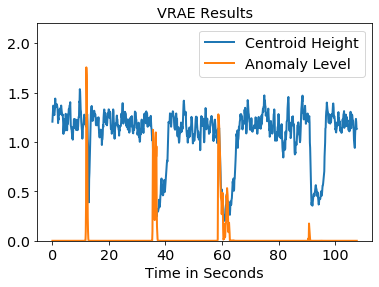

INFO: Model loaded from /content/drive/My Drive/Colab/saved_model/VRAE_SL_mdl.h5
INFO: Start to predict...
INFO: Prediction is done!


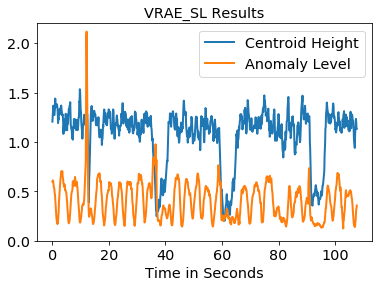

INFO: Start to predict...
INFO: Prediction is done!


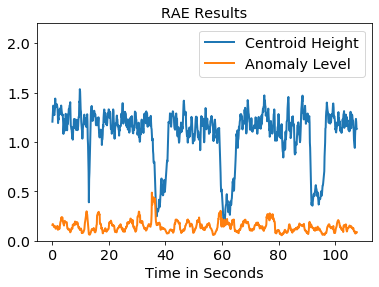

In [8]:
    # Load inference dataset and the ground truth timesheet
    inferencedata_file                      = project_path + 'data/D1/D1_4falls'
    inferencedata, centroidZ_history        = data_preproc().load_bin(inferencedata_file + '.npy', fortrain=False)
    # Ground truth time index file exists
    if os.path.exists(inferencedata_file + '.csv'): 
        gt_falls_idx                        = np.genfromtxt(inferencedata_file + '.csv', delimiter=',').astype(int)
    # Maybe this file doesn't contain any falls
    else: 
        gt_falls_idx                        = []

    # Load the models
    model                                   = autoencoder_mdl(model_dir = project_path + 'saved_model/')
    
    VRAE_loss_history                       = model.VRAE_predict(inferencedata)
    plt.figure()
    plt.ylim(0.0, 2.2)
    plt.xlabel("Time in Seconds")
    time_step = np.arange(0, len(centroidZ_history))*0.1 # 0.1 seconds per frame
    plt.plot(time_step, centroidZ_history, linewidth=2, label='Centroid Height')
    plt.plot(time_step, VRAE_loss_history, linewidth=2, label='Anomaly Level')
    plt.legend(loc="upper right")
    plt.title('VRAE Results')
    plt.savefig(inferencedata_file+'_VRAE_prediction.png')
    plt.show()

    VRAE_SL_loss_history                    = model.VRAE_SL_predict(inferencedata)
    plt.figure()
    plt.ylim(0.0, 2.2)
    plt.xlabel("Time in Seconds")
    time_step = np.arange(0, len(centroidZ_history))*0.1 # 0.1 seconds per frame
    plt.plot(time_step, centroidZ_history, linewidth=2, label='Centroid Height')
    plt.plot(time_step, VRAE_SL_loss_history, linewidth=2, label='Anomaly Level')
    plt.legend(loc="upper right")
    plt.title('VRAE_SL Results')
    plt.savefig(inferencedata_file+'_VRAE_SL_prediction.png')
    plt.show()

    RAE_loss_history                        = model.RAE_predict(inferencedata)
    plt.figure()
    plt.ylim(0.0, 2.2)
    plt.xlabel("Time in Seconds")
    time_step = np.arange(0, len(centroidZ_history))*0.1 # 0.1 seconds per frame
    plt.plot(time_step, centroidZ_history, linewidth=2, label='Centroid Height')
    plt.plot(time_step, RAE_loss_history, linewidth=2, label='Anomaly Level')
    plt.legend(loc="upper right")
    plt.title('RAE Results')
    plt.savefig(inferencedata_file+'_RAE_prediction.png')
    plt.show()

INFO: Total inference motion pattern data shape: (1033, 10, 64, 4)
INFO: Model loaded from /content/drive/My Drive/Colab/saved_model/VRAE_mdl.h5
INFO: Start to predict...
INFO: Prediction is done!


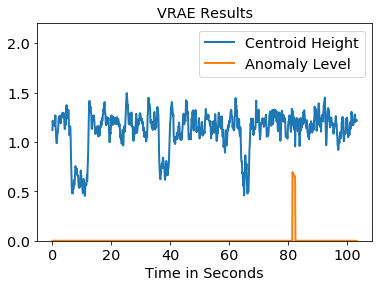

INFO: Model loaded from /content/drive/My Drive/Colab/saved_model/VRAE_SL_mdl.h5
INFO: Start to predict...
INFO: Prediction is done!


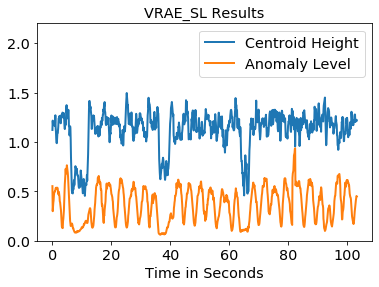

INFO: Start to predict...
INFO: Prediction is done!


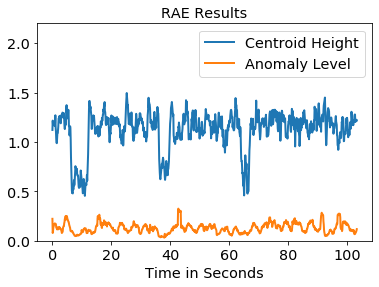

In [9]:
   # Load inference dataset and the ground truth timesheet
    inferencedata_file                      = project_path + 'data/D1/D1_4normal'
    inferencedata, centroidZ_history        = data_preproc().load_bin(inferencedata_file + '.npy', fortrain=False)
    # Ground truth time index file exists
    if os.path.exists(inferencedata_file + '.csv'): 
        gt_falls_idx                        = np.genfromtxt(inferencedata_file + '.csv', delimiter=',').astype(int)
    # Maybe this file doesn't contain any falls
    else: 
        gt_falls_idx                        = []

    # Load the models
    model                                   = autoencoder_mdl(model_dir = project_path + 'saved_model/')
    
    VRAE_loss_history                       = model.VRAE_predict(inferencedata)
    plt.figure()
    plt.ylim(0.0, 2.2)
    plt.xlabel("Time in Seconds")
    time_step = np.arange(0, len(centroidZ_history))*0.1 # 0.1 seconds per frame
    plt.plot(time_step, centroidZ_history, linewidth=2, label='Centroid Height')
    plt.plot(time_step, VRAE_loss_history, linewidth=2, label='Anomaly Level')
    plt.legend(loc="upper right")
    plt.title('VRAE Results')
    plt.savefig(inferencedata_file+'_VRAE_prediction.png')
    plt.show()

    VRAE_SL_loss_history                    = model.VRAE_SL_predict(inferencedata)
    plt.figure()
    plt.ylim(0.0, 2.2)
    plt.xlabel("Time in Seconds")
    time_step = np.arange(0, len(centroidZ_history))*0.1 # 0.1 seconds per frame
    plt.plot(time_step, centroidZ_history, linewidth=2, label='Centroid Height')
    plt.plot(time_step, VRAE_SL_loss_history, linewidth=2, label='Anomaly Level')
    plt.legend(loc="upper right")
    plt.title('VRAE_SL Results')
    plt.savefig(inferencedata_file+'_VRAE_SL_prediction.png')
    plt.show()

    RAE_loss_history                        = model.RAE_predict(inferencedata)
    plt.figure()
    plt.ylim(0.0, 2.2)
    plt.xlabel("Time in Seconds")
    time_step = np.arange(0, len(centroidZ_history))*0.1 # 0.1 seconds per frame
    plt.plot(time_step, centroidZ_history, linewidth=2, label='Centroid Height')
    plt.plot(time_step, RAE_loss_history, linewidth=2, label='Anomaly Level')
    plt.legend(loc="upper right")
    plt.title('RAE Results')
    plt.savefig(inferencedata_file+'_RAE_prediction.png')
    plt.show()

INFO: Total inference motion pattern data shape: (60278, 10, 64, 4)













INFO: Model loaded from /content/drive/My Drive/Colab/saved_model/VRAE_mdl.h5
INFO: Start to predict...
INFO: Prediction is done!
INFO: Model loaded from /content/drive/My Drive/Colab/saved_model/VRAE_SL_mdl.h5
INFO: Start to predict...
INFO: Prediction is done!


INFO: Start to predict...
INFO: Prediction is done!
How many falls? 50
How many falls? 50
How many falls? 50


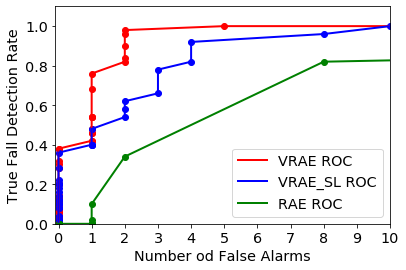

In [0]:
      # Load inference dataset and the ground truth timesheet
    inferencedata_file                      = project_path + 'data/D2/D2'
    inferencedata, centroidZ_history        = data_preproc().load_bin(inferencedata_file + '.npy', fortrain=False)
    # Ground truth time index file exists
    if os.path.exists(inferencedata_file + '.csv'): 
        gt_falls_idx                        = np.genfromtxt(inferencedata_file + '.csv', delimiter=',').astype(int)
    # Maybe this file doesn't contain any falls
    else: 
        gt_falls_idx                        = []

    # Load the models
    model                                   = autoencoder_mdl(model_dir = project_path + 'saved_model/')
    VRAE_loss_history                       = model.VRAE_predict(inferencedata)
    VRAE_SL_loss_history                    = model.VRAE_SL_predict(inferencedata)
    RAE_loss_history                        = model.RAE_predict(inferencedata)
    
    # For performace evaluation
    calculator                              = compute_metric()
    VARE_tpr, VARE_fp_total                 = calculator.cal_roc(VRAE_loss_history, centroidZ_history, gt_falls_idx)
    VARE_SL_tpr, VARE_SL_fp_total           = calculator.cal_roc(VRAE_SL_loss_history, centroidZ_history, gt_falls_idx)
    RAE_tpr, RAE_fp_total                   = calculator.cal_roc(RAE_loss_history, centroidZ_history, gt_falls_idx)

    # Plot Receiver operating characteristic (ROC) curves
    plt.figure()
    plt.xlim(-0.1, 10)
    plt.xticks(np.arange(0, 11, 1))
    plt.ylim(0.0, 1.1)
    plt.scatter(VARE_fp_total, VARE_tpr, c='r')
    plt.plot(VARE_fp_total, VARE_tpr, c='r', linewidth=2, label='VRAE ROC')
    plt.xlim(-0.1, 10)
    plt.xticks(np.arange(0, 11, 1))
    plt.ylim(0.0, 1.1)
    plt.scatter(VARE_SL_fp_total, VARE_SL_tpr, c='b')
    plt.plot(VARE_SL_fp_total, VARE_SL_tpr, c='b', linewidth=2, label='VRAE_SL ROC')
    plt.xlim(-0.1, 10)
    plt.xticks(np.arange(0, 11, 1))
    plt.ylim(0.0, 1.1)
    plt.scatter(RAE_fp_total, RAE_tpr, c='g')
    plt.plot(RAE_fp_total, RAE_tpr, c='g', linewidth=2, label='RAE ROC')
    plt.legend(loc="lower right")
    plt.xlabel("Number od False Alarms")
    plt.ylabel("True Fall Detection Rate")
    plt.savefig(inferencedata_file + '_ROC.png')
    plt.show()